# Machine Learning - Practical 6

Names: {YOUR NAMES}

In [1]:
import pickle
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import seaborn as sns
from numpy import linalg as LA
sns.set(context='talk',style='white',palette='colorblind')

## Task 0: Load data

To explore different clustering algorithms, we generated a toy dataset that consists of 5000 data points from a two dimensional mixture of Gaussian model with seven clusters.
Plot the data points with different colors for each cluster and indicated the cluster means.

In [2]:
# load data
with open('data_gmms.pkl', 'rb') as f:
    dataset = pickle.load(f)

In [29]:
data = dataset["data"]
label = dataset["labels"]
means = dataset["means"]
data.shape,np.unique(label),means.shape

((5000, 2), array([0., 1., 2., 3., 4., 5., 6.]), (7, 2))

In [4]:
data[:5]

array([[-0.40584013, -1.39006514],
       [-1.88108597, -2.08034997],
       [-0.85857129, -0.53322627],
       [-2.18863041, -2.08250738],
       [ 2.73584533, -1.81469468]])

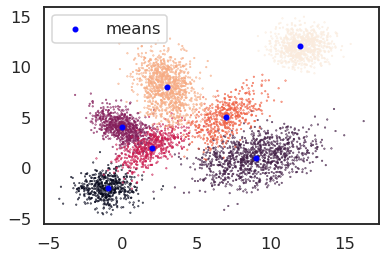

In [5]:
plt.scatter(data[:,0],data[:,1],s=.3,c=label)
plt.scatter(means[:,0],means[:,1],c="blue",s=20,label="means")
plt.legend()

In [6]:
def plot_clustering(data, cluster_ids, means, title):
    '''
    Plots the (2D) data as scatter plot, with different colors and an extra symbol for the mean per cluster.
    inputs:
        data        -- (n_samples, n_features)-shaped array of data
        cluster_ids -- (n_samples,)-shaped array of integers that hold the cluster assignment for each data point
        means       -- (n_clusters, n_features)-shaped array of mean vectors
        title       -- string that is added as title

    '''

    # ---------------- INSERT CODE ----------------------
    fig,ax = plt.subplots(figsize=(10,6))
    ax.scatter(data[:,0],data[:,1],s=2,c=cluster_ids)
    ax.scatter(means[:,0],means[:,1],c="blue",s=80,label="means",marker="x")
    ax.legend()
    plt.title(title)
    
    # ---------------- END CODE -------------------------

In [7]:
toy_data = dataset['data']
toy_cluster_ids_true = dataset['labels']
toy_means = dataset['means']

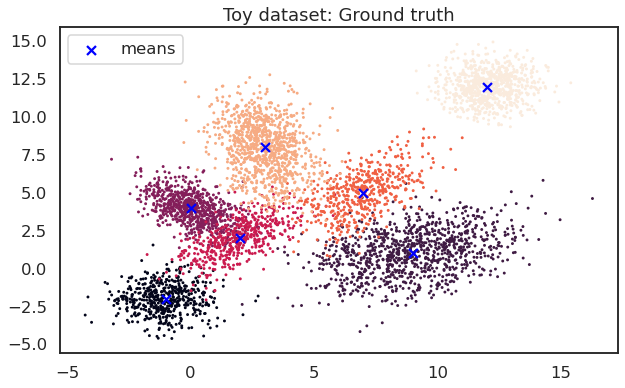

In [8]:
plot_clustering(toy_data, toy_cluster_ids_true, toy_means, 'Toy dataset: Ground truth')

## Task 1: Cluster the data using k-Means

First, we will implement k-Means as an example of a simple clustering algorithm and see how it performs on the dataset. 

Use the function KMeans provided by sklearn to perform K-Means with different numbers of clusters, for instance 3, 5, 7, 10 and 20.

In [12]:
def run_KMeans(data, n_clusters):
    '''Function that performs K-means clustering for a given number of clusters.
        input:
            data: (n_samples, n_features)-shaped array of data
            number of clusters: int, number of clusters
        output:
            kmeans_result: (n_samples,)-shaped array of integers that hold the cluster assignment for each data point
    '''

    # ---------------- INSERT CODE ----------------------
    kMeans = KMeans(n_clusters=n_clusters).fit(data)
    kmeans_result=kMeans.labels_ 
    
    
    # ---------------- END CODE -------------------------
    return kmeans_result,kMeans.cluster_centers_

In [14]:
# run kmeans with different numbers of clusters

# ---------------- INSERT CODE ----------------------
ks=[3,5,7,10,20]
results=[]
mean_res=[]
for k in ks:
    Km,meansr =run_KMeans(data, k)
    results.append(Km)
    mean_res.append(meansr)
results=np.array(results)
results.shape
# ---------------- END CODE -------------------------

(5, 5000)

Plot your results as cluster labels using the "plot_clustering" function and compare it to the original cluster labels. Describe your results.

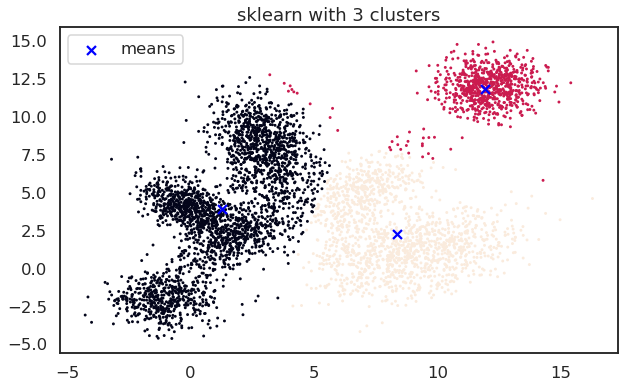

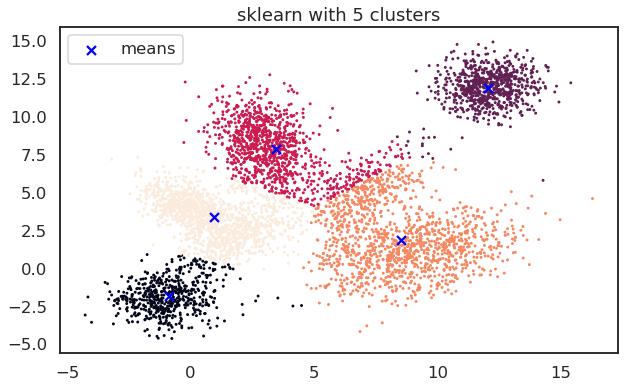

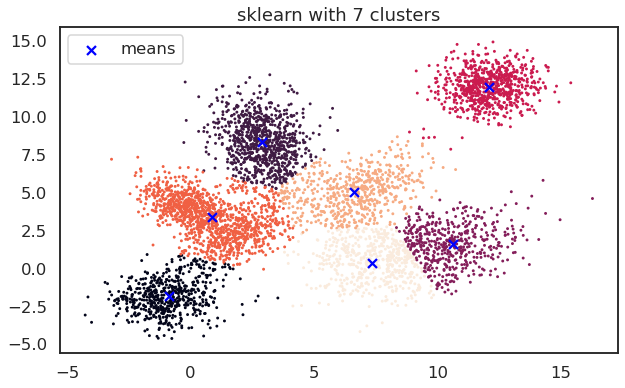

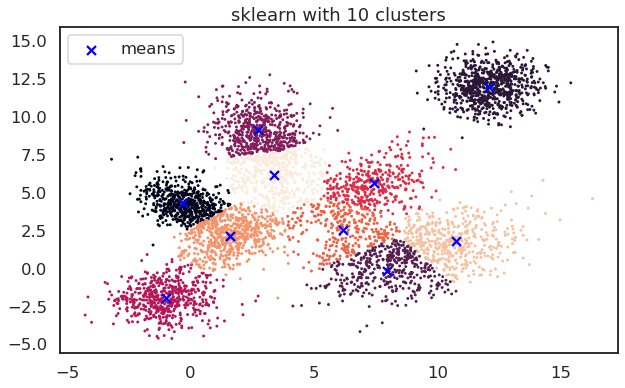

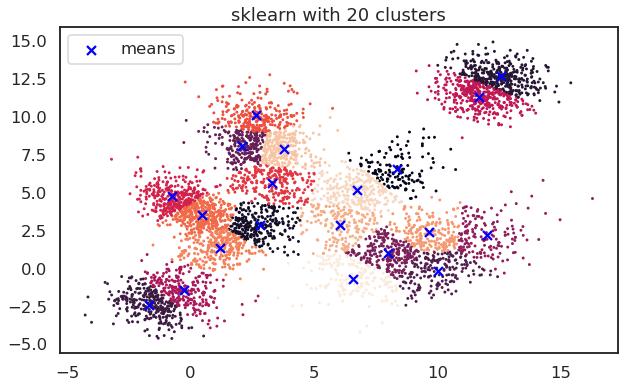

In [15]:
# plot results
# ---------------- INSERT CODE ----------------------
for i in range(5):
    plot_clustering(data, results[i], mean_res[i], "sklearn with %d clusters"%ks[i])


# ---------------- END CODE -------------------------

YOUR ANSWER HERE

##  Task 2: Clustering using Gaussian Mixture Models

Next, we will implement clustering with Gaussian Mixture models as discussed in the Bishop in Chapter 9.2.2 pg. 435-439.

Implement the EM algorithm to fit a Gaussian mixture model on the data. Sort the data points by inferring their class labels from your mixture model (by using maximum a-posteriori classification). Fix the seed of the random number generator to ensure deterministic and reproducible behavior. 

For this task, it is important to think about a good way to initialize the means, covariances and mixing coefficients. Also, during optimization, covariance matrices can become singular. To prevent this, you can add a small constant (like $10^{-5}$) to the diagonal.

In order to speed up the computation, define a convergence criterion that stops the algorithm after convergence.

In [31]:
import random

In [32]:
from scipy.stats import multivariate_normal

In [35]:
def gmm(data, n_clusters, verbose=True, max_iter=1000, convergence_threshold=1e-4):
    '''Function that fits a mixture of gaussians to data.

        inputs:
            data          -- (n_samples, n_features)-shaped array of data points
            n_clusters    -- int, number of clusters / mixture components
            verbose       -- bool, if True, print current likelihood after each EM iteration
            max_iter      -- maximum number of EM iterations
            convergence_threshold  -- stop algorithm if change in log-lieklihood is below the treshold

        outputs:
            cluster_ids -- (n_samples,)-shaped array of integers that hold the cluster assignment for each data point
            means       -- (n_clusters, n_features)-shaped array of fit mean vectors
            covs        -- (n_features, n_features, n_clusters)-shaped array of fit covariance matrices
            priors      -- (n_clusters)-shaped arrays of fit priors / mixing coefficients
        '''

    # ---------------- INSERT CODE ----------------------

    ### INITIALIZATION ###
    random.seed(9) #9super
    kmeans_result,_=run_KMeans(data, n_clusters)
    priors = np.zeros(n_clusters)
    means = np.zeros((n_clusters, data.shape[1]))
    reg = 1e-5
    covs = np.zeros((data.shape[1],data.shape[1],n_clusters))
    rand=random.sample(range(0, data.shape[0]), n_clusters)
    resb = np.zeros((data.shape[0],n_clusters))
    Nk = np.zeros(n_clusters)
    N = data.shape[0]
    #K-Means for initialization of cov and priors
    for i in range(n_clusters):
        means[i]=data[rand[i]]
        priors[i]=sum(kmeans_result==i)/kmeans_result.shape[0]
        covs[:,:,i]=np.cov(data[kmeans_result==i].T)+reg*np.identity(data.shape[1])
    """
    for k in range(n_clusters):
        Nk[k]=1/n_clusters
        for i in range(data.shape[1]):
            means[k,i]=random.uniform(-2, 2)
            covs[:,:,k]=np.cov(means[k])+reg*np.identity(data.shape[1])"""
    iterat=1
    #pdf=multivariate_normal.pdf(data,means[0],covs[:,:,0])
    log_like = 0
    multi =np.zeros((data.shape[0],n_clusters))
    for n in range(data.shape[0]):
        var = 0
        for k in range(n_clusters):
            #print(covs[:,:,k])
            multi[n,k]=multivariate_normal.pdf(data[n],means[k],covs[:,:,k])
            var+=priors[k]*multi[n,k]
        log_like+=np.log(var)
    ### ALTERNATE BETWEEN E & M STEP ###
    while(iterat<max_iter):
        iterat+=1
        ### E-STEP ###
        for n in range(data.shape[0]):
            nenn = 0
            for j in range(n_clusters):
                nenn+=priors[j]*multi[n,j]
            for k in range(n_clusters):
                resb[n,k]=priors[k]*multi[n,k]/nenn
        ### M-STEP ###
        for k in range(n_clusters):
            Nk[k]=sum(resb[:,k])
        for k in range(n_clusters):
            sum_1=0
            sum_2=np.zeros((data.shape[1],data.shape[1]))
            for n in range(data.shape[0]):
                sum_1+=resb[n,k]*data[n]
            means[k]=sum_1/Nk[k]
            priors[k]=Nk[k]/data.shape[0]
            for n in range(data.shape[0]):
                sum_2+=resb[n,k]*np.outer(data[n]-means[k],(data[n]-means[k]).T)/Nk[k]
            covs[:,:,k]=sum_2+reg*np.identity(data.shape[1])
        ### CHECK FOR CONVERGENCE/ PRINT LOG_LIKELIHOOD if VERBOSE ###
        new_log = 0
        for n in range(data.shape[0]):
            var = 0
            for k in range(n_clusters):
                multi[n,k]=multivariate_normal.pdf(data[n],means[k],covs[:,:,k])
                var+=priors[k]*multi[n,k]
            new_log+=np.log(var)
        if(verbose):
            print(new_log)
        if(np.abs(new_log-log_like)<convergence_threshold):
            break
        log_like=new_log
    ### ASSIGN CLUSTER LABELS ###
    cluster_ids=np.zeros(data.shape[0])
    apost=np.zeros(n_clusters)
    for n in range(data.shape[0]):
        for k in range(n_clusters):
            apost[k]=multi[n,k]*priors[k]
        cluster_ids[n]=np.argmax(apost)
    # ---------------- END CODE -------------------------

    return (cluster_ids, means, covs, priors)

Explore the results of GMM using different numbers of clusters and initialization strategies.

In [36]:
# fit GMM
(cluster_ids, meansGMM, covs, priors)=gmm(data, 7, verbose=True, max_iter=20, convergence_threshold=1e-4)

-26006.6920593435
-25747.360651181152
-25525.27204585539
-25291.329573112736
-25065.589362202634
-24953.95950870632
-24930.90418484199
-24919.423322505358
-24908.884075736503
-24898.307511789
-24888.12816402198
-24879.378190165444
-24872.798246498933
-24868.314291942366
-24865.339662690752
-24863.29265314778
-24861.798260717278
-24860.653988826947
-24859.753172054843


Plot the data points from the toy dataset and indicate in color the cluster each point was assigned to by your model. How does the assignment compare to ground truth? How does it compare to the k-Means solution? Plot ground truth, k-Means and GMM cluster assignment side-by-side to compare them.

If you run the algorithm multiple times, you will notice that some solutions provide suboptimal clustering solutions - depending on your initialization strategy.

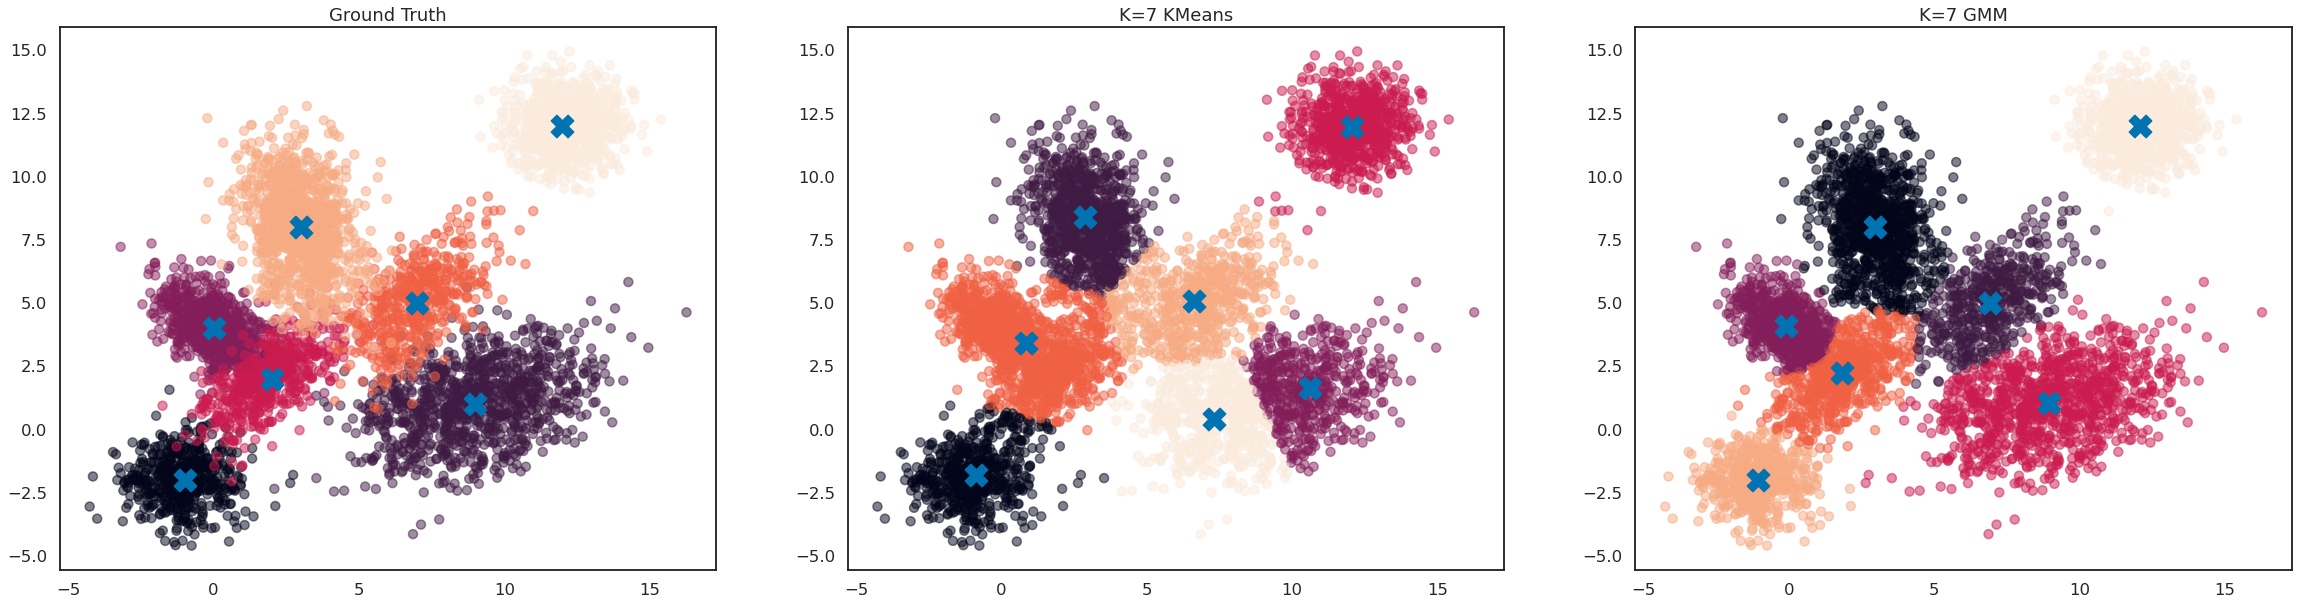

In [61]:
fig,axes = plt.subplots(1,3,figsize=(40,10))
axes[0].scatter(data[:,0],data[:,1],c=label,alpha=.5)
axes[0].scatter(means[:,0],means[:,1],color="b",s=500,marker="X")
axes[0].set_title("Ground Truth")
axes[1].scatter(data[:,0],data[:,1],c=results[2],alpha=.5)
axes[1].scatter(mean_res[2][:,0],mean_res[2][:,1],color="b",s=500,marker="X")
axes[1].set_title("K=7 KMeans")
axes[2].scatter(data[:,0],data[:,1],c=cluster_ids,alpha=.5)
axes[2].scatter(meansGMM[:,0],meansGMM[:,1],color="b",s=500,marker="X")
axes[2].set_title("K=7 GMM")
plt.show()

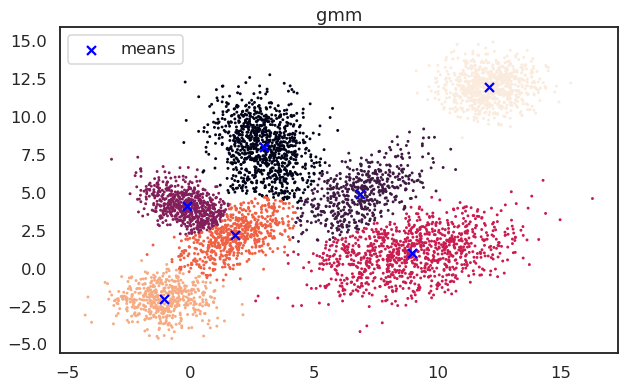

In [17]:
# plotting
plot_clustering(data, cluster_ids, means, "gmm")

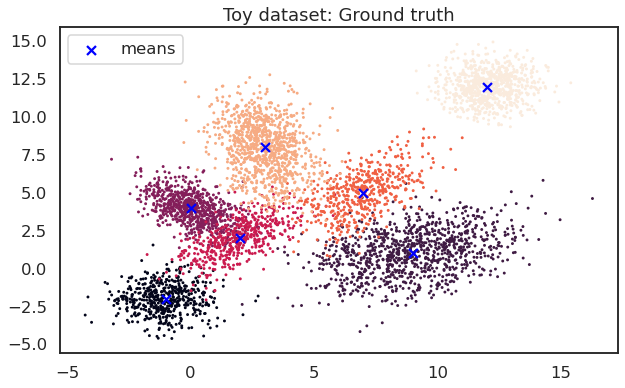

In [18]:
plot_clustering(data, toy_cluster_ids_true, toy_means, 'Toy dataset: Ground truth')

In [19]:

from sklearn.mixture import GaussianMixture


In [20]:
np.random.seed(1)
g = GaussianMixture(n_components=7)
g.fit(data) 

GaussianMixture(n_components=7)

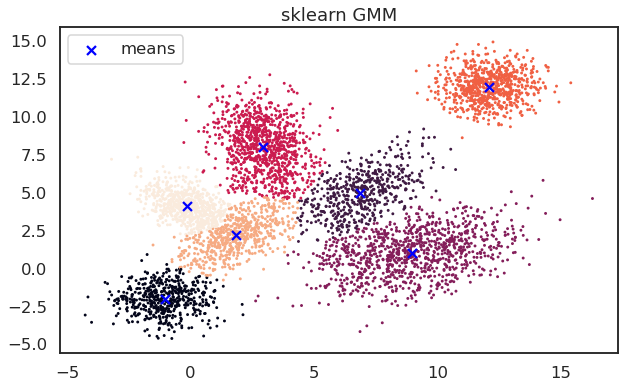

In [21]:
plot_clustering(toy_data, g.predict(data), g.means_ , 'sklearn GMM')

YOUR ANSWER HERE

In [85]:
def KMeans1(data,k,max_it):
    #init
    means = np.zeros((k,data.shape[1]))
    rand=random.sample(range(0, data.shape[0]), k)
    for i in range(k):
        means[i]=data[rand[i]]
    #kmeans
    it=0
    while(it<max_it):
        labels = np.zeros(data.shape[0])
        dist = np.zeros(k)
        for n in range(data.shape[0]):
            for c in range(k):
                dist[c]=LA.norm(data[n]-means[c])
            labels[n]=np.argmin(dist)
        for i in range(k):
            means[i]=np.mean(data[labels==i],axis=0)
        if(it%10==0):
            print("iteration:%d"%it)
        it+=1
    for n in range(data.shape[0]):
            for c in range(k):
                dist[c]=LA.norm(data[n]-means[c])
            labels[n]=np.argmin(dist)
    return means,labels

In [86]:
means,labels= KMeans1(data,7,30)

iteration:0
iteration:10
iteration:20


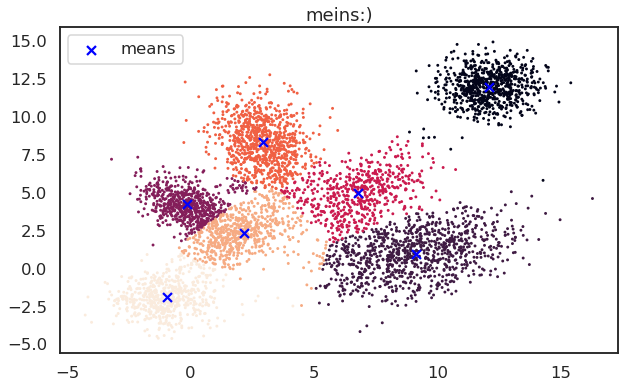

In [87]:
plot_clustering(data, labels, means, "meins:)")